# Mean-field simulations of fluctuation-driven rate chaos

In [1]:
from itertools import product as cprod
import matplotlib.pyplot as plt
import numpy as np
import os
from scipy import stats
import sys

from time_stats import get_isi_cv_2, xcov_conv_tri

from disp import set_plot

LOAD_DIR = '7C_rate_chaos_full'

D = 200
K_OUT = 30
SGM_OUT = .2

N = 2000

NTWK_SEED = 0
START_SEEDS = range(2)

T_MAX = 2000

D=200, K_OUT=30, SGM_OUT=0.2


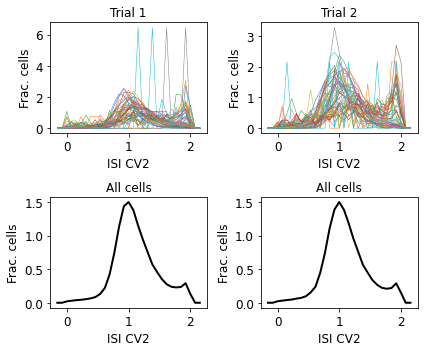

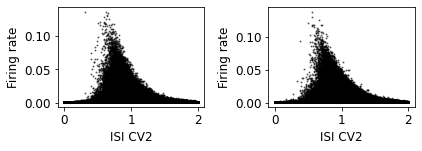

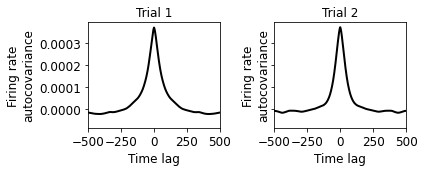

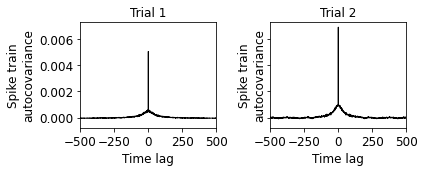

In [2]:
PLOT_SPIKES = False

NPLOT_COTUNED = 2
print(f'D={D}, K_OUT={K_OUT}, SGM_OUT={SGM_OUT}')

NNRN_ACOV = 100

ds_plot_isi_cv = range(50)

bins = np.linspace(-0.2, 2.2, 32)
binc = .5*(bins[:-1] + bins[1:])

NTR = len(START_SEEDS)

if PLOT_SPIKES:
    fig, axs = plt.subplots(NTR, 2, figsize=(16, 3*NTR), tight_layout=True, squeeze=False)
    
fig_isi, axs_isi = plt.subplots(2, NTR, figsize=(3*NTR, 5), tight_layout=True)
fig_fr_v_isi, axs_fr_v_isi = plt.subplots(1, NTR, figsize=(3*NTR, 2.2), tight_layout=True)
fig_fr_acov, axs_fr_acov = plt.subplots(1, NTR, figsize=(3*NTR, 2.5), sharey=True, tight_layout=True)
fig_spk_acov, axs_spk_acov = plt.subplots(1, NTR, figsize=(3*NTR, 2.5), sharey=True, tight_layout=True)

for ctr, START_SEED in enumerate(START_SEEDS):
    
    fload = f'spikes' \
        + f'_D_{D}_K_OUT_{K_OUT}_SGM_OUT_{SGM_OUT}_N_{N}_T_MAX_{T_MAX}' \
        + f'_NTWK_SEED_{NTWK_SEED}_START_SEED_{START_SEED}.npy'

    data = np.load(os.path.join(LOAD_DIR, 'from_della', 'rate_chaos_spikes', fload), allow_pickle=True)[0]
    
    t = data['t']
    ys = data['ys']
    ths = data['ths']
    
    if PLOT_SPIKES:
        axs[ctr, 0].plot(t, ths, lw=.5)
        set_plot(axs[ctr, 0], x_label='Time', y_label='Firing rate', title=f'Initialization {ctr+1}')

        for d in range(D):
            inrns = np.random.permutation(N)[:NPLOT_COTUNED]
            tspks, cspks = ys[:, inrns, d].nonzero()
            axs[ctr, 1].scatter(tspks, cspks+d*NPLOT_COTUNED, marker='|', lw=.5)

        set_plot(axs[ctr, 1], x_label='Time', y_label='Population', title=f'Trial {ctr+1}')
            
    for d in ds_plot_isi_cv:
        isi_cvs = [get_isi_cv_2(ys[:, i, d]) for i in range(N)]
        cts = np.histogram(isi_cvs, bins=bins, density=True)[0]

        axs_isi[0, ctr].plot(binc, cts, lw=.5)

    set_plot(axs_isi[0, ctr], x_label='ISI CV2', y_label='Frac. cells', title=f'Trial {ctr+1}')
    
    # all ISIs
    isi_cvs_all = np.array([get_isi_cv_2(ys[:, i, d]) for i, d in cprod(range(N), range(D))])
    cts_all = np.histogram(isi_cvs_all, bins=bins, density=True)[0]
    axs_isi[1, ctr].plot(binc, cts_all, lw=2, c='k')
    
    set_plot(axs_isi[1, ctr], x_label='ISI CV2', y_label='Frac. cells', title=f'All cells')
    
    # firing rate vs ISI
    frs_all = np.array([ys[:, i, d].mean() for i, d in cprod(range(N), range(D))])
    
    mvalid = ~np.isnan(isi_cvs_all)
    
    axs_fr_v_isi[ctr].scatter(isi_cvs_all, frs_all, s=1, c='k', alpha=.5)
    
    set_plot(axs_fr_v_isi[ctr], x_label='ISI CV2', y_label='Firing rate')
    
    # firing rate and spike autocovs
    fr_acov_tcovs = [xcov_conv_tri(ths[:, d], ths[:, d]) for d in range(D)]
    fr_tcov = fr_acov_tcovs[0][1]
    fr_acov_mn = np.mean([fr_acov for fr_acov, fr_tcov in fr_acov_tcovs], axis=0)
    axs_fr_acov[ctr].plot(fr_tcov, fr_acov_mn, lw=2, c='k')
        
    set_plot(axs_fr_acov[ctr], x_lim=(-T_MAX/4, T_MAX/4), x_ticks=[-500, -250, 0, 250, 500], x_label='Time lag', y_label='Firing rate\nautocovariance', title=f'Trial {ctr+1}')
    
    spk_acov_tcovs = [xcov_conv_tri(ys[:, i, d], ys[:, i, d]) for i, d in zip(np.random.randint(0, N, NNRN_ACOV), np.random.randint(0, D, NNRN_ACOV))]
    spk_tcov = spk_acov_tcovs[0][1]
    spk_acov_mn = np.mean([spk_acov for spk_acov, spk_tcov in spk_acov_tcovs], axis=0)
    axs_spk_acov[ctr].plot(spk_tcov, spk_acov_mn, lw=1, c='k')
    
    set_plot(axs_spk_acov[ctr], x_lim=(-T_MAX/4, T_MAX/4), x_ticks=[-500, -250, 0, 250, 500], x_label='Time lag', y_label='Spike train\nautocovariance', title=f'Trial {ctr+1}')

In [3]:
if PLOT_SPIKES:
    fig.savefig('figs/main/8_rate_spikes_examples_full.svg')
fig_isi.savefig('figs/main/8_isi_examples_full.svg')
fig_fr_v_isi.savefig('figs/main/8_fr_v_isi_examples_full.png', dpi=200)
fig_fr_acov.savefig('figs/main/8_rate_acov_examples_full.svg')
fig_spk_acov.savefig('figs/main/8_spk_acov_examples_full.svg')